In [ ]:
"""
Required Installations
"""

!pip uninstall umap
!pip install umap-learn



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""
                                                Latent Semantic Analysis


Golbal Variables:
    i) data_df: A dataframe containing the news data (Raw Data)
    ii) vector_tdif: Vectorization instance
    iii) X: vectorized data of the news data "data_df" (Document-Term Matrix in other words)
    iv) dictionary: Container of all the important words from all the documents
    v) lsa_model: TruncatedSVD instance (Signullar Value Decomposition)
    vi) topic_encoded_data: The Latent Semantic Analysis output (Topic Encoding of the given data) 


Results: 
    i) Shows the probabilty of hidden topics on each document
    ii) Shows most frequent 10 words from each topic
    ii) Shows clusters on topics


"""

'\n                                                Latent Semantic Analysis\n\n\nGolbal Variables:\n    i) data_df: A dataframe containing the news data (Raw Data)\n    ii) vector_tdif: Vectorization instance\n    iii) X: vectorized data of the news data "data_df" (Document-Term Matrix in other words)\n    iv) dictionary: Container of all the important words from all the documents\n    v) lsa_model: TruncatedSVD instance (Signullar Value Decomposition)\n    vi) topic_encoded_data: The Latent Semantic Analysis output (Topic Encoding of the given data) \n\n\nResults: \n    i) Shows the probabilty of hidden topics on each document\n    ii) Shows most frequent 10 words from each topic\n    ii) Shows clusters on topics\n\n\n'

In [ ]:
"""
Imports
"""

import nltk
import string
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE


In [ ]:
"""
Required Downloads
"""

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
"""
Functions
"""

def load_data():
  """""
  Returns:
      data_df: the dataframe containing the news data
  Function Description: 
      i) Fetch 20newsgroups data
      ii) Removes unnecessay things such as headers, footers and the quotes
      iii) Add the target names also as an additional column along with the target for better representation
  """""
  remove_list = ['headers', 'footers', 'quotes']
  data = fetch_20newsgroups(subset="all", random_state=2, remove=remove_list, shuffle=True)
  data_df = pd.DataFrame({'News': data.data, 'Target': data.target})
  data_df['Target_Name'] = data_df['Target'].apply(lambda x: data.target_names[x])
  return data_df


# Reserve the news data in a global dataframe & show first 10 values
data_df = load_data()
data_df.head(10)

    

,News,Target,Target_Name
0,"In <C601ED.CD6@cpqhou.se.hou.compaq.com>, thom...",16,talk.politics.guns
1,ajteel@dendrite.cs.Colorado.EDU (A.J. Teel) w...,18,talk.politics.misc
2,"Look, folks, I don't know what happened in Wac...",16,talk.politics.guns
3,\nYou can't be serious! I and many of my coll...,10,rec.sport.hockey
4,Does anyone know if there is a carrying case f...,4,comp.sys.mac.hardware
5,"\n\n\nIt works for me. I avoid obscenities, an...",8,rec.motorcycles
6,\n\nOne can't. The application may not have b...,5,comp.windows.x
7,"Hello,\n\nI am looking for a PC card with the ...",3,comp.sys.ibm.pc.hardware
8,"\nI suppose it's too late now, but the repeate...",16,talk.politics.guns
9,Am I the only person who thinks the Reds sleev...,9,rec.sport.baseball


In [ ]:
"""
Functions Continued....
"""


def preprocess_data(line):
    """""
    Parameters:
        line: Each line(sentence) of the data
    Returns:
        line: Parameter "line" after processing
    Function Description:
       i) Make the sentence lowercase
       ii) Remove all the things that are not alphabets (i.e. digits, punctuations, etc.)
       iii) Tokenize the words from the line (Make "token" list)
       iv) Remove English stopwords (i.e. "the", "a", "an", "to", etc.) from the "token" list
       v) We're assuming the words having length less than 2 are not that important, so not taking them
       vi) Lemmatize the words in the "token" list
       vii) Join all the new words, and put it on the "line"
       viii) Return line 
    """""
    line = line.lower()
    pat = re.compile(r'[^a-z]+')
    line = pat.sub(' ', line).strip()
    tokens = word_tokenize(line)
    eng_stopwords = set(stopwords.words('english'))
    tokens = [word for word in tokens if ( (word not in eng_stopwords) and (len(word) > 2) )]
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens]
    line = ' '.join(tokens)
    return line




#Preprocess the data and store the new cleaned values to data_df['News'], tqdm from pandas is used to see the progress of the cleaning process
tqdm.pandas()
data_df['News'] = data_df['News'].progress_apply(lambda x: preprocess_data(str(x)))




100%|██████████| 18846/18846 [00:28<00:00, 662.82it/s]


In [ ]:
"""
Functions Continued....
"""


def make_lsa_model(n_components):
    """""
    Returns:
        X: Scaled document-term matrix 
        dictionary: All the important words from all the documents
        lsa_model: A TruncatedSVD instance
        topic_encoded_data: Fitted scaled data "X" to TruncatedSVD instance "lsa_model" (actual output of lsa)
    Function Description:
       i) We'll at first create the document-term matrix using TfidfVectorizer
          * min_df=1: We're taking the words that appered in at least one document
          * max_df=0.5: We won't take the words that appeared on more than 50% of the documents, as they are so common. 
                      These too common words don't help us to distinguish the clusters.
       ii) Transform the data to be best fit, and put it on the variable "X"
       iii) From the scaled data "X", we've saved the important words on a variable "dictionary"
       iv) Then, we'll make a model to reduce the dimension of our data using TruncatedSVD (It's called Signullar Value Decomposition).
           * We've used n_components=20 to make 20 clusters for our 20 topics.
           * Algorithm 'arpack' is used instead of 'randomized' as arpack provided better performance than randomized.
           * We've named the model "lsa_model"
       v) Then, we fit our scaled data "X" to out "lsa_model" (This is called "Topic Encoding"). 
       vi) Now, out Latent Semantic Analysis process is finised, we can return the variables, 
           which we'll use to represnt out analysis 
    """"" 
    vector_tdif = TfidfVectorizer(min_df=1, max_df=0.5, tokenizer=lambda x: str(x).split())  #Text Vectorization
    X = vector_tdif.fit_transform(data_df['News'])
    dictionary = vector_tdif.get_feature_names_out()
    lsa_model = TruncatedSVD(n_components=n_components, algorithm='arpack') #TruncatedSVD instance (Signullar Value Decomposition)
    topic_encoded_data = lsa_model.fit_transform(X) #Topic Encoding Data
    return vector_tdif, X, dictionary, lsa_model, topic_encoded_data



# Preserve the Scaled document-term matrix(X), important words(dictionary), the TruncatedSVD instance(lsa_model), the lsa output(topic_encoded_data)
vector_tdif, X, dictionary, lsa_model, topic_encoded_data = make_lsa_model(20) # Cluster for 20 Topics




In [ ]:
"""
Functions Continued....
"""

def show_document_encoding_matirx(num_of_topic):
  """""
    Parameters:
      num_of_topic: In how many topics we want to clusterize our dataset
    Returns:
      topic_encoded_df: dataframe having the topic encoded data
    Function Description:
      Put the lsa output topic encoded data to a DataFrame, and return  
  """""
  topic_list = ['Topic '+str(i) for i in range(num_of_topic)]
  #As the news data actually has 20 topic distributions, we can use the documents as indexes while clustering in 20 topics
  if num_of_topic==20:
    topic_encoded_df = pd.DataFrame(topic_encoded_data, index=data_df['News'], columns=topic_list)
  else:
    topic_encoded_df = pd.DataFrame(topic_encoded_data, columns=topic_list)  
  return topic_encoded_df


#Show first 10 rows from the topic encoded matrix, where it shows the probablity to be in each topic for each document
topic_encoded_df = show_document_encoding_matirx(20)
topic_encoded_df.head(10)



,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
News,,,,,,,,,,,,,,,,,,,,
cpqhou hou compaq com thomasr cpqhou hou compaq com sez terribly interesting belong misc legal take elsewhere please hugged common nucleus operative fact today,0.034776,0.004943,-0.007667,-0.005294,0.005094,0.026250,0.001031,-0.006438,0.017628,0.020192,0.022700,0.025452,-0.014585,0.032992,-0.030944,-0.004458,0.017173,0.026786,-0.037447,0.016539
ajteel dendrite colorado edu teel writes wrong possible inherit debt see constitution contract statute please teel anyone show one case constitution state constitution considered contract also designed delineate power government wait daniel reitman write deed one case involved construction conveyance grantee jointly tenant common equal right interest said land survivor thereof fee simple hold unto said party hereto equally jointly tenant common equal right interest period term life survivor thereof death,0.102986,-0.044720,-0.008649,0.002767,0.026781,0.014339,-0.029608,-0.007626,0.049748,0.004618,0.012848,0.025423,0.004986,0.044056,-0.014833,-0.001737,-0.027899,0.013763,0.035210,0.015341
look folk know happened waco claim bd angel never koresh may well devil incarnate know know must question single source information must question even harder given single source insistance government ever else happened waco perhaps biggest evil done even light discrepencies turning federal official state official really understand hoard devoted government worshiper believe government could possibly wrong fanatic point making thing brent microwave oven disclaim using fire food heating hard pressed see real difference claimed power koresh held bd demonstrated power government hold rapid apologist jim jmd handheld com,0.174434,-0.072726,-0.019434,0.009115,0.058129,-0.002836,-0.020803,-0.012762,0.039941,-0.053704,0.000482,0.006891,0.016777,0.039253,-0.046330,-0.050892,-0.005818,0.035724,0.034798,-0.016372
serious many colleague received bad mail roger fact roger happens answered hockey question curiosity start flaming roger better consider nasty attitude towards roger like,0.067884,-0.019271,0.021850,-0.020876,-0.019124,0.020106,0.004511,-0.012451,0.006888,-0.011308,0.000900,0.011061,-0.014790,0.007567,-0.005218,0.019965,0.010590,-0.023193,-0.017850,0.002344
anyone know carrying case centris thanks info,0.110435,0.096274,-0.028248,-0.029152,-0.036379,0.236590,-0.008082,-0.023066,0.035804,-0.163020,0.022211,-0.042921,0.084846,-0.066079,-0.068746,0.003761,-0.065372,0.089721,0.076943,-0.061869
work avoid obscenity try remain calm cool collected try something like almost killed moving apologize something le benign like shot single time texas plenty witness around,0.102829,-0.016245,0.017213,-0.008547,0.003625,-0.017405,-0.034430,0.015222,-0.028445,-0.014233,-0.032503,-0.008146,-0.000067,-0.029155,-0.024211,-0.013673,-0.013456,-0.024409,-0.040703,0.020870
one application may started terminal emulator terminal emulator may still exist may condition pop ped top may iconified even may want consider virtual root window manager like tvtwm relevant window portion virtual desktop outside real desktop terminal emulator provide environment variable giving window even thing present environment may want may correspond window different server example der mouse,0.135083,0.084737,-0.104313,-0.096338,-0.044442,-0.139349,-0.045502,0.022096,-0.043340,-0.036362,0.117671,0.068487,-0.052402,-0.023389,-0.013627,0.037937,0.019892,-0.053508,0.055303,0.022852
hello looking card following feature controller ide bus harddiskdrive controller floppydiskdrives standard vga graphic including feature connector important manufacturors distributor kind card found yet help please mail ich djukfa ich zam zam kfa juelich,0.068884,0.108061,0.009018,0.069356,-0.031264,0.057594,0.032276,0.089600,0.096114,0.003128,-0.016990,-0.013104,0.032604,0.056483,0.02866

In [ ]:
"""
Functions Continued....
"""

def show_top_topic_word(components, dictionary):
    """""
    Parameters:
        components: The lsa_model components, which are topics actually
        dictionary: The words
    Returns:
        top_words: Most frequent 10 words from each topic
    Function Description:
       i) Sort the words on a topic based on their probablities
       ii) The words that have higher frequencies have higher probalities
       ii) Return 10 words with the highest frequncy
    """""
    top_words = pd.Series([],dtype=pd.StringDtype())
    for idx, component in enumerate(components):
        topics = pd.Series(component, index=dictionary)
        # Sort the topics based on the probality values
        topics.sort_values(ascending=False, inplace=True)
        top_words["Topic "+str(idx)] = list(topics.iloc[:10].index)
    return top_words


# Show 10 most frequent words on each topic
top_10words = show_top_topic_word(lsa_model.components_, dictionary)
print("Topics\t\tWords")
for idx, item in zip(top_10words.index, top_10words):
    print(idx,'\t',item)

Topics		Words
Topic 0 	 ['would', 'one', 'know', 'like', 'get', 'people', 'think', 'time', 'could', 'window']
Topic 1 	 ['window', 'drive', 'file', 'card', 'thanks', 'do', 'disk', 'driver', 'program', 'system']
Topic 2 	 ['game', 'drive', 'team', 'year', 'player', 'car', 'hockey', 'fan', 'season', 'scsi']
Topic 3 	 ['drive', 'scsi', 'god', 'disk', 'ide', 'controller', 'hard', 'card', 'floppy', 'meg']
Topic 4 	 ['key', 'chip', 'government', 'encryption', 'clipper', 'phone', 'escrow', 'law', 'system', 'algorithm']
Topic 5 	 ['thanks', 'please', 'anyone', 'mail', 'know', 'email', 'advance', 'would', 'looking', 'address']
Topic 6 	 ['key', 'game', 'god', 'chip', 'bit', 'clipper', 'encryption', 'card', 'system', 'team']
Topic 7 	 ['card', 'driver', 'monitor', 'video', 'car', 'color', 'bus', 'mhz', 'mode', 'vga']
Topic 8 	 ['armenian', 'card', 'israel', 'game', 'people', 'jew', 'muslim', 'arab', 'government', 'turkish']
Topic 9 	 ['edu', 'file', 'image', 'armenian', 'sale', 'new', 'god', 'of

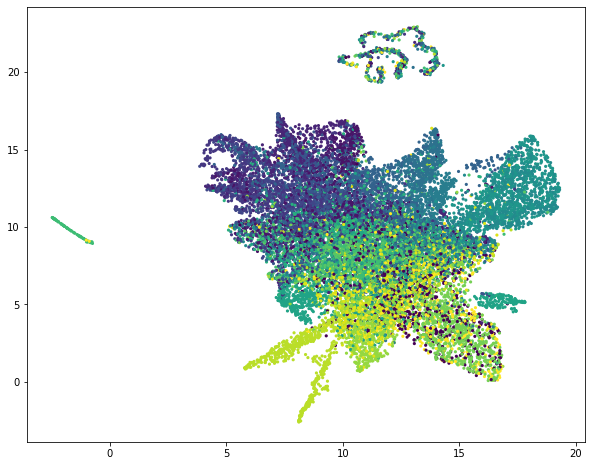

In [ ]:
"""
Functions Continued....
"""

def show_lsa_clusters():
  """
    Functions Description: Shows the topic clusters from out LSA output "topic_encoded_data"
  """
  embedding = umap.UMAP(min_dist=0.5, random_state=5).fit_transform(topic_encoded_data)
  plt.figure(figsize=(10,8))
  plt.scatter(  embedding[:, 0], embedding[:, 1], 
                c = data_df['Target'],
                s = 10, # size
                edgecolor='none'
             )
  plt.show()



#Show the clusters in out Latent Semantic Analysis
show_lsa_clusters() 


In [ ]:
"""

                                                        Model Tuning

"""

In [ ]:
"""
Model Tuning:
  Cluster the dataset into 6 topics instead of 20
"""

vector_tdif, X, dictionary, lsa_model, topic_encoded_data = make_lsa_model(6)


#Show first 10 rows from the topic encoded matrix, where it shows the probablity to be in each topic for each document
topic_encoded_df = show_document_encoding_matirx(6)
topic_encoded_df.head(10)





,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.034776,0.004943,-0.007667,-0.005294,0.005094,0.026250
1,0.102986,-0.044720,-0.008649,0.002767,0.026781,0.014339
2,0.174434,-0.072726,-0.019434,0.009115,0.058129,-0.002836
3,0.067884,-0.019271,0.021850,-0.020876,-0.019124,0.020106
4,0.110435,0.096274,-0.028248,-0.029152,-0.036379,0.236590
5,0.102829,-0.016245,0.017213,-0.008547,0.003625,-0.017405
6,0.135083,0.084737,-0.104313,-0.096338,-0.044442,-0.139349
7,0.068884,0.108061,0.009018,0.069356,-0.031264,0.057594
8,0.088853,-0.049819,-0.016915,0.000721,0.034515,-0.027026
9,0.056533,-0.016878,0.011389,-0.018748,-0.016867,-0.009672


In [ ]:
# Show 10 most frequent words on each topic
top_10words = show_top_topic_word(lsa_model.components_, dictionary)
print("Topics\t\tWords")
for idx, item in zip(top_10words.index, top_10words):
    print(idx,'\t',item)

Topics		Words
Topic 0 	 ['would', 'one', 'know', 'like', 'get', 'people', 'think', 'time', 'could', 'window']
Topic 1 	 ['window', 'drive', 'file', 'card', 'thanks', 'do', 'disk', 'driver', 'program', 'system']
Topic 2 	 ['game', 'drive', 'team', 'year', 'player', 'car', 'hockey', 'fan', 'season', 'scsi']
Topic 3 	 ['drive', 'scsi', 'god', 'disk', 'ide', 'controller', 'hard', 'card', 'floppy', 'meg']
Topic 4 	 ['key', 'chip', 'government', 'encryption', 'clipper', 'phone', 'escrow', 'law', 'system', 'algorithm']
Topic 5 	 ['thanks', 'please', 'anyone', 'mail', 'know', 'email', 'advance', 'would', 'looking', 'address']


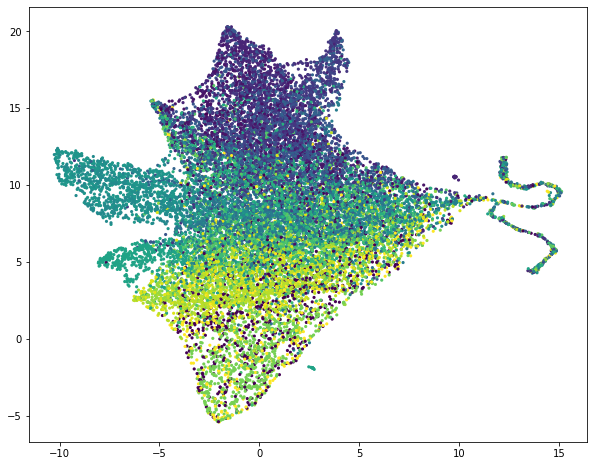

In [ ]:
#Show the clusters in out Latent Semantic Analysis
show_lsa_clusters() 